# Build and Evaluate Models

Pre-Processing
*   SMOTE
*   Normalize

Models
* Logistic Regression
* Linear SVC
* KNeighborhs 
* Random Forest

In [26]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import datetime
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt

sns.set()
# sns.reset_origin() # reverse of set

In [17]:
features_s = pd.read_csv("clean_data/features_s.csv").iloc[:,1:]
features_m = pd.read_csv("clean_data/features_m.csv").iloc[:,1:]
features = pd.read_csv("clean_data/features_all.csv").iloc[:,1:]
outcomes = pd.read_csv("clean_data/outcomes.csv").iloc[:,1:]
df = pd.read_csv("clean_data/full_clean_data.csv").iloc[:,1:]

## SMOTE

In [19]:
smote = SMOTE()

def smote_col(col, feats):
  '''
  SMOTE (balance binary classes)
  for an outcome column in df
  based on inputted features df
  '''
  x_smote, y_smote = smote.fit_resample(feats.astype(float), outcomes[col])
  
  x_smote = pd.DataFrame(x_smote)
  x_smote.columns = feats.columns

  y_smote = pd.DataFrame(y_smote)
  y_smote.columns = [col]

  return x_smote, y_smote

In [21]:
#smote each feature set
feature_sets = {"features": features, 
                "features_m": features_m,
                "features_s": features_s}

smotes = {}
for time in ["1Y", "5Y"]:
  for measure in ["Median", "75th"]: 
    for feat_set, features in feature_sets.items() :
      var = "Gentrified " + time + " " + measure
      x, y = smote_col(var, features)
      smotes[var] = smotes.get(var, {}) 
      smotes[var][feat_set] = {"X": x, "y": y}  

## Pipeline

In [41]:
# --- Grid Search --- # 
def grid_search(X, y, models, parameters, time, feat_set):
    """
    Looks for the best model based off a list of models and their parameters
    """    
    # Begin timer 
    start = datetime.datetime.now()

    # Initialize results data frame 
    results = []

    # Loop over models 
    for model_key in models.keys(): 

        # Loop over parameters 
        for params in parameters[model_key]: 
            print("Training model:", model_key, "|", params)
            
            # Create model 
            model = models[model_key]
            model.set_params(**params)
            #print("Model:", model)
            
            # Normalize Features
            new_model = Pipeline([('scaler', StandardScaler()), ('model', model)])

            # Run Cross Validation
            scoring = ('accuracy',
                       'precision',
                       'recall',
                       'f1')
            scores = cross_validate(new_model, X, y, cv=5, scoring=scoring)
            
            # Store average reults from cross-validations in results data frame 
            result = [time,
                      feat_set,
                      model_key,
                      params,
                      scores["test_accuracy"].mean(),
                      scores["test_precision"].mean(),
                      scores["test_recall"].mean(),
                      scores["test_f1"].mean()]
            
            #print(result)
            results.append(result)
            
    # End timer
    stop = datetime.datetime.now()
    print("Time Elapsed:", stop - start) 
    return results
       

In [42]:
# Config: Dictionaries of models and hyperparameters
models = {
    'LogisticRegression': LogisticRegression(), 
    'LinearSVC': LinearSVC(), 
    'KNeighbors': KNeighborsClassifier(), 
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
}

grid = {
    'LogisticRegression': [{'penalty': x, 'C': y, 'random_state': 0, 'max_iter': 5000} 
                           for x in ('l2', 'none') \
                           for y in (0.01, 0.1, 1, 10, 100)],
    'LinearSVC': [{'C': x, 'random_state': 0, 'dual': False} \
                  for x in (0.01, 0.1, 1, 10, 100)],
    'KNeighbors': [{'n_neighbors':x, "weights":y, "metric":z} \
                   for x in (1, 3,5,11,19) \
                   for y in ('uniform','distance') \
                   for z in ('euclidean','manhattan')], 
    'DecisionTree': [{'criterion':x, "max_depth":y, "min_samples_split":z} \
                   for x in ('gini', 'entropy') \
                   for y in (1,3,5) \
                   for z in (2,5,10)],
    'RandomForest': [{'criterion':x, "max_depth":y, "min_samples_split":z, "n_estimators":a} \
                   for x in ('gini', 'entropy') \
                   for y in (1,3,5) \
                   for z in (2,5,10) \
                   for a in (100,1000,5000)]
}

full_results = pd.DataFrame(columns=['Outcome Timeframe',
                                     'Feature Set',
                                     'Model',
                                     'Parameters', 
                                     'Accuracy',
                                     'Precision',
                                     'Recall',
                                     'F1 Score'])

#run grid search on each outcome and feature set
for time in ["1Y", "5Y"]:
    for feat_set, features in feature_sets.items() :
      var = "Gentrified " + time + " Median"
      results = grid_search(smotes[var][feat_set]["X"],
                            smotes[var][feat_set]["y"].values.ravel(),
                            models, grid, time, feat_set)
      results_df = pd.DataFrame(results, columns=['Outcome Timeframe',
                                                    'Feature Set',
                                                    'Model',
                                                    'Parameters', 
                                                    'Accuracy',
                                                    'Precision',
                                                    'Recall',
                                                    'F1 Score'])
      full_results = full_results.append(results_df)

Training model: LogisticRegression | {'penalty': 'l2', 'C': 0.01, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 0.1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 10, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'l2', 'C': 100, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 0.01, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cat

Training model: LogisticRegression | {'penalty': 'none', 'C': 0.1, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 10, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cat

Training model: LogisticRegression | {'penalty': 'none', 'C': 100, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LinearSVC | {'C': 0.01, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 0.1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 10, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 100, 'random_state': 0, 'dual': False}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metri

Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy',

/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cat

Training model: LogisticRegression | {'penalty': 'none', 'C': 0.1, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 10, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cat

Training model: LogisticRegression | {'penalty': 'none', 'C': 100, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LinearSVC | {'C': 0.01, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 0.1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 10, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 100, 'random_state': 0, 'dual': False}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metri

Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy',

/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cat

Training model: LogisticRegression | {'penalty': 'none', 'C': 0.1, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 10, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cat

Training model: LogisticRegression | {'penalty': 'none', 'C': 100, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LinearSVC | {'C': 0.01, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 0.1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 10, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 100, 'random_state': 0, 'dual': False}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metri

Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy',

/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cat

Training model: LogisticRegression | {'penalty': 'none', 'C': 0.1, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 10, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 100, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LinearSVC | {'C': 0.01, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 0.1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 10, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 100, 'random_state': 0, 'dual': False}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metri

Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy',

/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cat

Training model: LogisticRegression | {'penalty': 'none', 'C': 0.1, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 10, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cat

Training model: LogisticRegression | {'penalty': 'none', 'C': 100, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LinearSVC | {'C': 0.01, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 0.1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 10, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 100, 'random_state': 0, 'dual': False}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metri

Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy',

/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cat

Training model: LogisticRegression | {'penalty': 'none', 'C': 0.1, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LogisticRegression | {'penalty': 'none', 'C': 1, 'random_state': 0, 'max_iter': 5000}
Training model: LogisticRegression | {'penalty': 'none', 'C': 10, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/cat

Training model: LogisticRegression | {'penalty': 'none', 'C': 100, 'random_state': 0, 'max_iter': 5000}


/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/catonbrewster/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


Training model: LinearSVC | {'C': 0.01, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 0.1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 1, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 10, 'random_state': 0, 'dual': False}
Training model: LinearSVC | {'C': 100, 'random_state': 0, 'dual': False}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'distance', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'euclidean'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'uniform', 'metric': 'manhattan'}
Training model: KNeighbors | {'n_neighbors': 3, 'weights': 'distance', 'metri

Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 5, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 100}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 1000}
Training model: RandomForest | {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 5000}
Training model: RandomForest | {'criterion': 'entropy',

In [71]:
full_results.sort_values(["Accuracy", "Recall", "F1 Score"], ascending = False).head(50)

,Outcome Timeframe,Outcome Benchmark,Feature Set,Model,Parameters,Accuracy,Precision,Recall,F1 Score
15,5Y,NaN,features,KNeighbors,"{'n_neighbors': 1, 'weights': 'uniform', 'metr...",0.958952,0.930385,0.996970,0.961576
17,5Y,NaN,features,KNeighbors,"{'n_neighbors': 1, 'weights': 'distance', 'met...",0.958952,0.930385,0.996970,0.961576
16,5Y,NaN,features,KNeighbors,"{'n_neighbors': 1, 'weights': 'uniform', 'metr...",0.957425,0.933074,0.990816,0.960027
18,5Y,NaN,features,KNeighbors,"{'n_neighbors': 1, 'weights': 'distance', 'met...",0.957425,0.933074,0.990816,0.960027
15,5Y,NaN,features_s,KNeighbors,"{'n_neighbors': 1, 'weights': 'uniform', 'metr...",0.957414,0.928011,0.996923,0.960146
17,5Y,NaN,features_s,KNeighbors,"{'n_neighbors': 1, 'weights': 'distance', 'met...",0.957414,0.928011,0.996923,0.960146
16,5Y,NaN,features_s,KNeighbors,"{'n_neighbors': 1, 'weights': 'uniform', 'metr...",0.955910,0.926972,0.996923,0.959206
18,5Y,NaN,features_s,KNeighbors,"{'n_neighbors': 1, 'weights': 'distance', 'met...",0.955910,0.926972,0.996923,0.959206
16,5Y,NaN,features_m,KNeighbors,"{'n_neighbors': 1, 'weights': 'uniform', 'metr...",0.949838,0.922986,0.987832,0.953247
18,5Y,NaN,features_m,KNeighbors,"{'n_neighbors': 1, 'weights': 'distance', 'met...",0.949838,0.922986,0.987832,0.953247


## Selecting the Best Model

In [73]:
sorted_best = full_results.sort_values(["Accuracy", "Recall", "F1 Score"], ascending = False)

top_model = sorted_best.iloc[0,]['Model']
top_timeframe = "Gentrified " + sorted_best.iloc[0,]['Outcome Timeframe'] + " Median"
top_feat = sorted_best.iloc[0,]['Feature Set'] 
top_params = sorted_best.iloc[0,]['Parameters']
print("Top model is", top_model, "with parameters", top_params)
print("Predicting", top_timeframe, "using", top_feat)

X_train, X_test, y_train, y_test = train_test_split(smotes[top_timeframe][top_feat]["X"],
                                                    smotes[top_timeframe][top_feat]["y"],
                                                    test_size=0.2,
                                                    random_state=0)

Top model is KNeighbors with parameters {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean'}
Predicting Gentrified 5Y Median using features


### Confirming Best K from Wider Range

In [74]:
k_dict = {}
best_accuracy = 0

for k in range(1, 20):
    knn = KNeighborsClassifier(n_neighbors = k,
                              weights = "distance",
                              metric = "manhattan")
    
    knn.fit(X_train, y_train.values.ravel())
    pred = knn.predict(X_test)
    acc = metrics.accuracy_score(y_test, pred)
    
    k_dict[k] = metrics.accuracy_score(y_test, pred)
    if acc > best_accuracy:
        best_accuracy = acc
        best_k = k

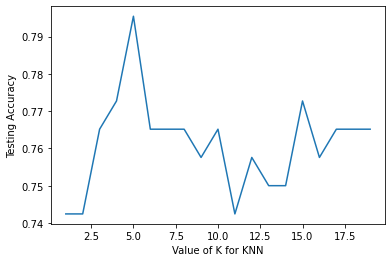

In [75]:
plt.plot(k_dict.keys(), k_dict.values())
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')
None

In [76]:
best_model = KNeighborsClassifier(n_neighbors = best_k, 
                        weights = 'distance',
                        metric = 'manhattan')

best_model.fit(X_train, y_train.values.ravel())
            
y_pred_best = best_model.predict(X_test)

### Precision-Recall

In [77]:
print("Accuracy is", sorted_best.iloc[0,]['Accuracy'])
print("Precision is", sorted_best.iloc[0,]['Precision'])
print("Recall is", sorted_best.iloc[0,]['Recall'])
print("F1 Score is", sorted_best.iloc[0,]['F1 Score'])

Accuracy is 0.9589521165857043
Precision is 0.9303847646620322
Recall is 0.9969696969696968
F1 Score is 0.9615756486099178


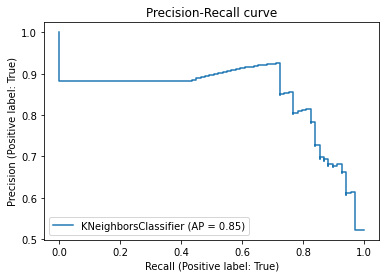

In [78]:
disp = metrics.plot_precision_recall_curve(best_model, X_test, y_test)
disp.ax_.set_title('Precision-Recall curve')

None

### Confusion Matrix

[[47 16]
 [11 58]]


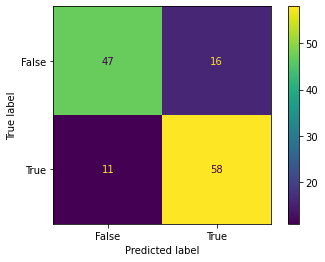

In [80]:
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve 

#sns.reset_orig()
plot_confusion_matrix(best_model,X_test,y_test)
print(metrics.confusion_matrix(y_test, y_pred_best))

## Selecting the Most Interpretable Model

In [81]:
sorted_intrp = full_results[full_results['Model'] != "KNeighbors"].sort_values(["Accuracy", "Recall"], 
                                                                                ascending = False)

intrp_model = sorted_intrp.iloc[0,]['Model']
intrp_timeframe = "Gentrified " + sorted_intrp.iloc[0,]['Outcome Timeframe'] + " Median"
intrp_feat = sorted_intrp.iloc[0,]['Feature Set']
intrp_params = sorted_intrp.iloc[0,]['Parameters']
print("Top interpretable model is", intrp_model, "with parameters", intrp_params)
print("Predicting", intrp_timeframe, "using", intrp_feat)

X_train, X_test, y_train, y_test = train_test_split(smotes[intrp_timeframe][intrp_feat]["X"],
                                                    smotes[intrp_timeframe][intrp_feat]["y"],
                                                    test_size=0.2,
                                                    random_state=0)

Top interpretable model is RandomForest with parameters {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
Predicting Gentrified 5Y Median using features_m


In [82]:
intrp_model = RandomForestClassifier(criterion = 'gini', 
                                     max_depth = 5, 
                                     min_samples_split = 2,
                                     n_estimators = 100)

intrp_model.fit(X_train, y_train.values.ravel())
            
y_pred_intrp = intrp_model.predict(X_test)

### Confusion Matrix

[[56  7]
 [ 2 67]]


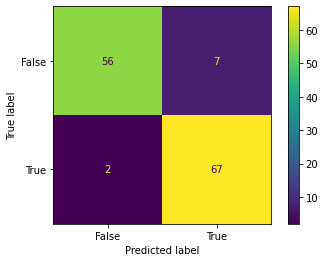

In [83]:
plot_confusion_matrix(intrp_model,X_test,y_test)
print(metrics.confusion_matrix(y_test, y_pred_intrp))

In [84]:
print("Accuracy is", sorted_intrp.iloc[0,]['Accuracy'])
print("Precision is", sorted_intrp.iloc[0,]['Precision'])
print("Recall is", sorted_intrp.iloc[0,]['Recall'])
print("F1 Score is", sorted_intrp.iloc[0,]['F1 Score'])

Accuracy is 0.9223455933379597
Precision is 0.8939474916533797
Recall is 0.9604662004662006
F1 Score is 0.925668925921804


### Feature Importance

In [98]:
index

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22])

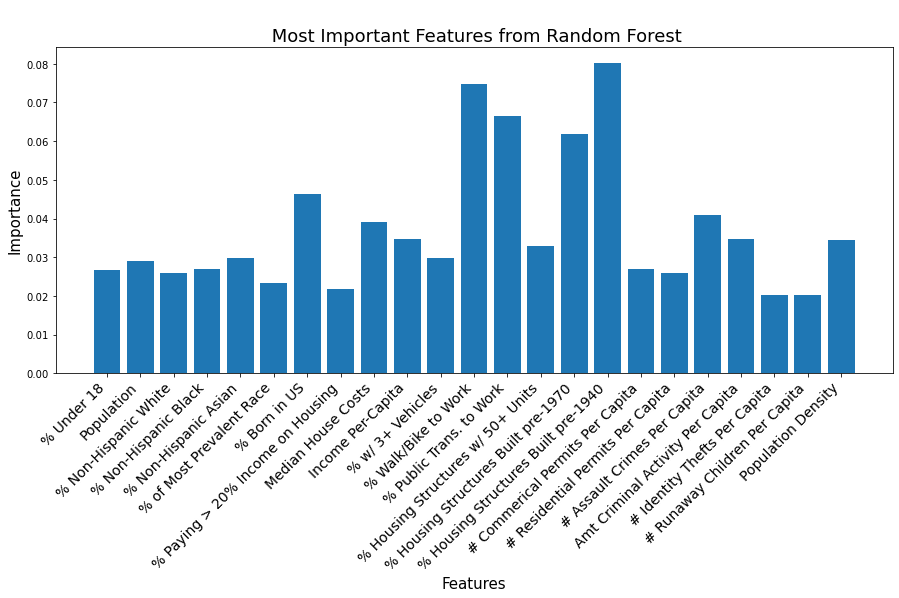

In [101]:
plt.figure(figsize=(15,6))

importances = intrp_model.feature_importances_
top_importances = importances[importances > .02]

names = ["% Under 18", "Population", "% Non-Hispanic White", "% Non-Hispanic Black", "% Non-Hispanic Asian", 
         "% of Most Prevalent Race", "% Born in US", "% Paying > 20% Income on Housing", "Median House Costs", 
         "Income Per-Capita", "% w/ 3+ Vehicles", "% Walk/Bike to Work", "% Public Trans. to Work", 
         "% Housing Structures w/ 50+ Units", "% Housing Structures Built pre-1970",
         "% Housing Structures Built pre-1940", "# Commerical Permits Per Capita", 
         "# Residential Permits Per Capita", "# Assault Crimes Per Capita", "Amt Criminal Activity Per Capita", 
         "# Identity Thefts Per Capita", "# Runaway Children Per Capita", "Population Density"]


index = top_importances
plt.bar(names, top_importances)

plt.xlabel('Features', size = 15)
plt.ylabel('Importance', size = 15)
plt.xticks(rotation=45, horizontalalignment='right', fontsize=14)
plt.title('\n Most Important Features from Random Forest', size = 18)

plt.show()